## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
from datetime import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc


### Read Routes and Incidents Datasets

In [2]:
routes_df=pd.read_csv("../Files/Routes.csv")
incidents_df=pd.read_csv("../Files/Incidents.csv")

## <span style="color: green;">Data Preprocessing for Incidents</span>


In [3]:
#size of the Dataset
incidents_df.shape



(138753, 6)

In [4]:
#display top 5 rows
incidents_df.head()

,Incident_Id,Route_Id,Incident_Type,Severity,Incident_Date,Description
0,INC00001,R0001,Economic Sanctions,High,13-10-2022,Trade restrictions affecting shipping routes a...
1,INC00002,R0001,Storage Limitations,High,05-02-2024,Limited space for storing goods at ports.
2,INC00003,R0001,Documentation Errors,Medium,07-06-2023,Incorrect or missing paperwork.
3,INC00004,R0001,Communication Breakdown,Medium,09-08-2023,"Miscommunication between ship, port, and logis..."
4,INC00005,R0001,Equipment Failure,Medium,20-05-2023,"Malfunctions in ships, cranes, or other equipm..."


In [5]:
#Verify the data types of the loaded dataset
incidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138753 entries, 0 to 138752
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Incident_Id    138753 non-null  object
 1   Route_Id       138753 non-null  object
 2   Incident_Type  138753 non-null  object
 3   Severity       138716 non-null  object
 4   Incident_Date  138753 non-null  object
 5   Description    138753 non-null  object
dtypes: object(6)
memory usage: 6.4+ MB


In [6]:
incidents_df['Incident_Date'] = pd.to_datetime(incidents_df['Incident_Date'],errors='coerce')
incidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138753 entries, 0 to 138752
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Incident_Id    138753 non-null  object        
 1   Route_Id       138753 non-null  object        
 2   Incident_Type  138753 non-null  object        
 3   Severity       138716 non-null  object        
 4   Incident_Date  138753 non-null  datetime64[ns]
 5   Description    138753 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 6.4+ MB


C:\Users\ponsi\AppData\Local\Temp\ipykernel_5872\1418933584.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  incidents_df['Incident_Date'] = pd.to_datetime(incidents_df['Incident_Date'],errors='coerce')


## Data Cleaning for Incidents

In [7]:
#Find Missing values
# total size 138451
incidents_df.nunique()

Incident_Id      138388
Route_Id           1000
Incident_Type        54
Severity              3
Incident_Date      1032
Description          54
dtype: int64

In [8]:
# Remove duplicate rows
# Before removing total size 138451
incidents_df = incidents_df.drop_duplicates()
incidents_df.shape


(138741, 6)

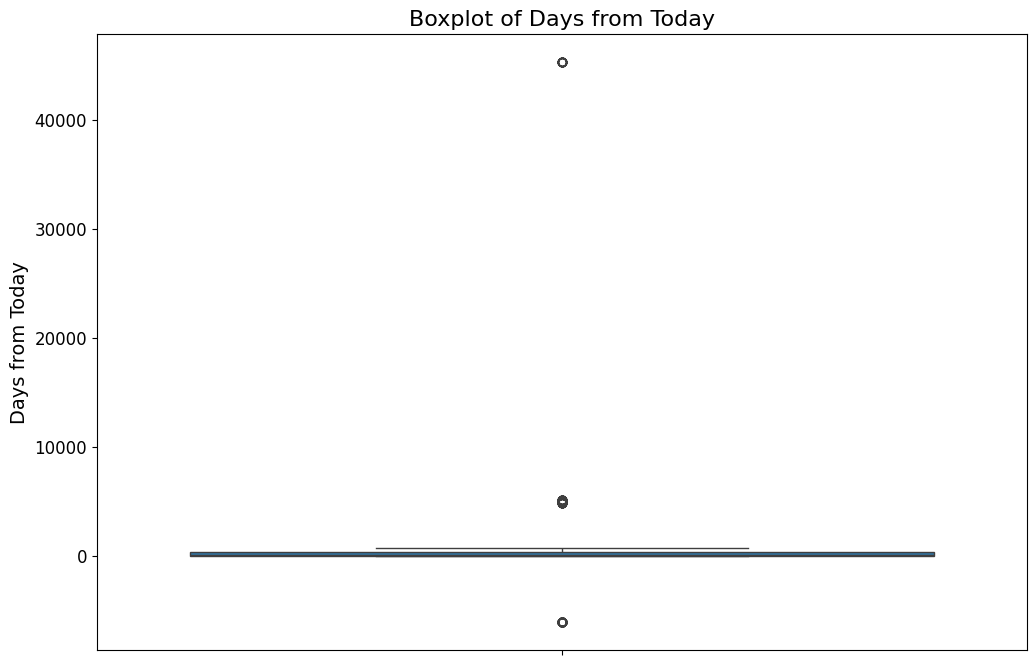

In [9]:
# Convert datetime to numerical format (days since the first date)
today = datetime.now()
incidents_df['Days_From_Today'] = (today - incidents_df['Incident_Date']).dt.days

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(y=incidents_df['Days_From_Today'])

# Customize plot appearance
plt.title('Boxplot of Days from Today', fontsize=16)  # Increase title font size
plt.ylabel('Days from Today', fontsize=14)  # Increase y-axis label font size
plt.xlabel('')  # Hide x-axis label
plt.xticks(fontsize=12)  # Increase x-axis tick labels font size
plt.yticks(fontsize=12)  # Increase y-axis tick labels font size
# Show the plot
plt.show()


In [10]:
incidents_df

,Incident_Id,Route_Id,Incident_Type,Severity,Incident_Date,Description,Days_From_Today
0,INC00001,R0001,Economic Sanctions,High,2022-10-13,Trade restrictions affecting shipping routes a...,663
1,INC00002,R0001,Storage Limitations,High,2024-02-05,Limited space for storing goods at ports.,183
2,INC00003,R0001,Documentation Errors,Medium,2023-06-07,Incorrect or missing paperwork.,426
3,INC00004,R0001,Communication Breakdown,Medium,2023-08-09,"Miscommunication between ship, port, and logis...",363
4,INC00005,R0001,Equipment Failure,Medium,2023-05-20,"Malfunctions in ships, cranes, or other equipm...",444
...,...,...,...,...,...,...,...
138748,INC138295,R0206,Route Blockages,Low,2041-02-27,Blocked shipping routes due to accidents or ge...,-6049
138749,INC138296,R0206,Intermodal Transfer Delays,Low,2041-02-28,Delays in transferring goods between different...,-6050
138750,INC138297,R0001,Communication Breakdown,Medium,2041-03-01,"Miscommunication between ship, port, and logis...",-6051
138751,INC137980,R0001,Equipment Failure,Medium,2041-03-02,"Malfunctions in ships, cranes, or other equipm...",-6052


## Identify and Remove Outliers Using the IQR Method

In [11]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = incidents_df['Days_From_Today'].quantile(0.25)
Q3 = incidents_df['Days_From_Today'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
filtered_df = incidents_df[(incidents_df['Days_From_Today'] >= lower_bound) & (incidents_df['Days_From_Today'] <= upper_bound)]

# Display the filtered DataFrame
print(filtered_df)

filtered_df.shape


       Incident_Id Route_Id             Incident_Type Severity Incident_Date  \
0         INC00001    R0001        Economic Sanctions     High    2022-10-13   
1         INC00002    R0001       Storage Limitations     High    2024-02-05   
2         INC00003    R0001      Documentation Errors   Medium    2023-06-07   
3         INC00004    R0001   Communication Breakdown   Medium    2023-08-09   
4         INC00005    R0001         Equipment Failure   Medium    2023-05-20   
...            ...      ...                       ...      ...           ...   
138446   INC138297    R0393         Equipment Failure      NaN    2023-08-13   
138447   INC137980    R0393                  LOS Full      NaN    2023-08-20   
138448   INC138295    R0393          Bunkering Delays      NaN    2023-12-15   
138449   INC138296    R0393            Customs Delays      NaN    2022-11-28   
138450   INC138297    R0393  Loading/Unloading Delays      NaN    2022-12-22   

                                       

(138439, 7)

In [12]:

print(incidents_df.shape)
incidents_df=filtered_df
print(incidents_df.shape)

(138741, 7)
(138439, 7)


### Missing Value Treatment

In [13]:

incidents_df.isnull()

,Incident_Id,Route_Id,Incident_Type,Severity,Incident_Date,Description,Days_From_Today
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
138446,False,False,False,True,False,False,False
138447,False,False,False,True,False,False,False
138448,False,False,False,True,False,False,False
138449,False,False,False,True,False,False,False


In [14]:
incidents_df.isnull().sum()

Incident_Id         0
Route_Id            0
Incident_Type       0
Severity           37
Incident_Date       0
Description         0
Days_From_Today     0
dtype: int64

In [15]:
incidents_df.isnull().sum() * 100 / incidents_df.shape[0]  # perc of missing values

Incident_Id        0.000000
Route_Id           0.000000
Incident_Type      0.000000
Severity           0.026727
Incident_Date      0.000000
Description        0.000000
Days_From_Today    0.000000
dtype: float64

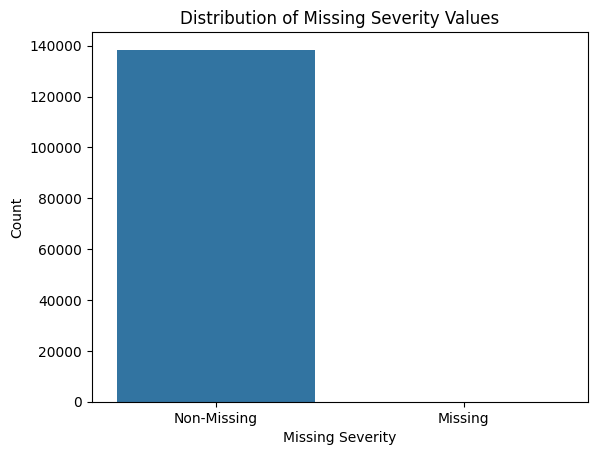

In [16]:
# Plot the distribution of missing and non-missing Severity values
sns.countplot(x=incidents_df['Severity'].isna())
plt.xlabel('Missing Severity')
plt.ylabel('Count')
plt.title('Distribution of Missing Severity Values')
plt.xticks([0, 1], ['Non-Missing', 'Missing'])
plt.show()

In [17]:
## Replace Missing Values with the Most Frequent Value
# Mode in the case of categorical variables


# Find the most frequent Severity value
most_frequent_severity = incidents_df['Severity'].mode()[0]

most_frequent_severity

'Low'

In [18]:
# Fill missing Severity with the most frequent value
incidents_df['Severity'].fillna(most_frequent_severity, inplace=True)

incidents_df.isnull().sum()

C:\Users\ponsi\AppData\Local\Temp\ipykernel_5872\2946859046.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  incidents_df['Severity'].fillna(most_frequent_severity, inplace=True)
C:\Users\ponsi\AppData\Local\Temp\ipykernel_5872\2946859046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incidents_df['Severity'].fillna(most_frequent_sever

Incident_Id        0
Route_Id           0
Incident_Type      0
Severity           0
Incident_Date      0
Description        0
Days_From_Today    0
dtype: int64

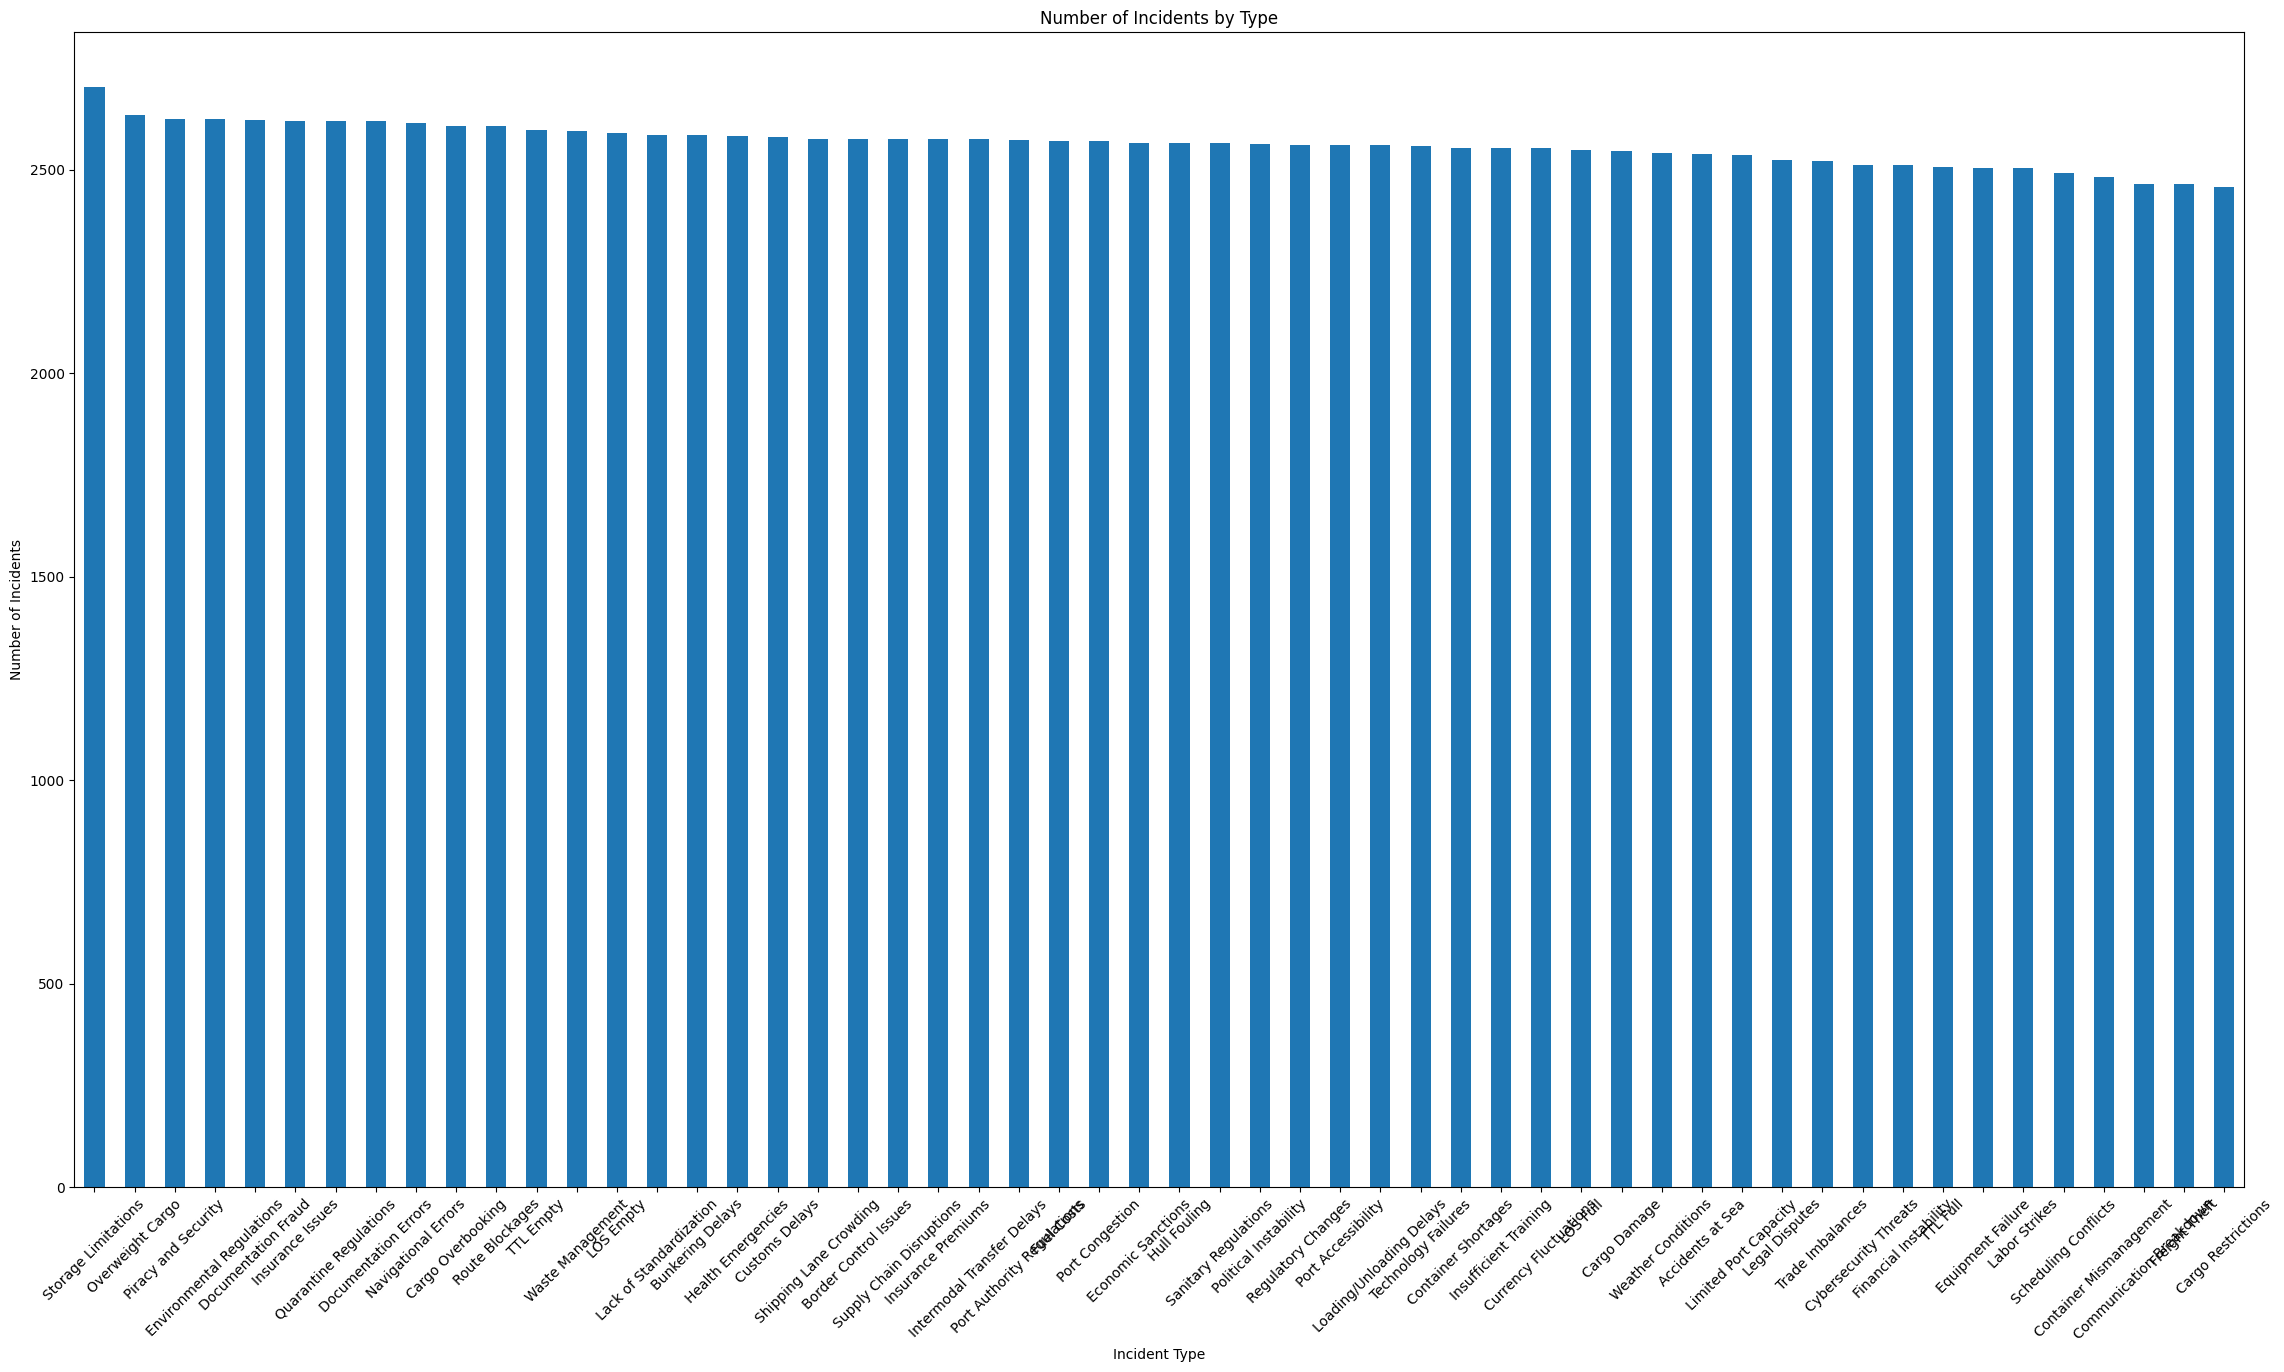

In [19]:
# Bar chart of incident types
plt.figure(figsize=(28, 15))
incidents_df['Incident_Type'].value_counts().plot(kind='bar')
plt.title('Number of Incidents by Type')
plt.xlabel('Incident Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45) 
plt.show()

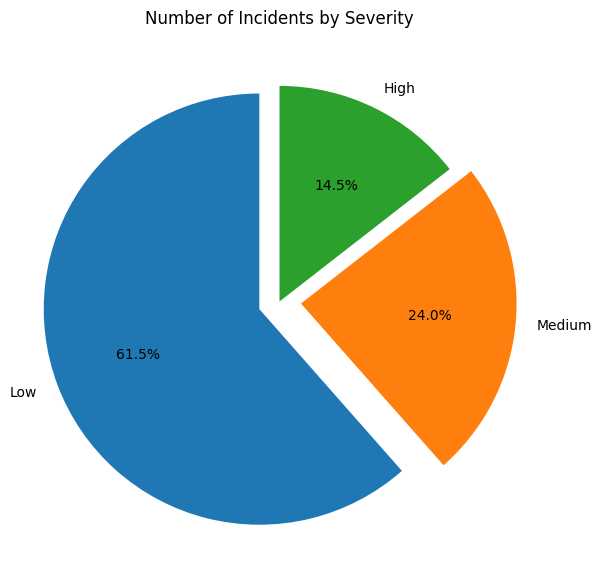

In [20]:
# Get value counts of Severity
severity_counts = incidents_df['Severity'].value_counts()

# Define which sections to highlight
# For example, let's highlight the first two sections
explode = [0.1 if i < 2 else 0 for i in range(len(severity_counts))]

# Create a pie chart with percentages and highlighted sections
plt.figure(figsize=(7, 7))
severity_counts.plot(kind='pie', autopct='%1.1f%%', explode=explode, startangle=90)
plt.title('Number of Incidents by Severity')
plt.ylabel('')
plt.show()

## <span style="color: green;">Data Preprocessing for Routes</span>


In [21]:
routes_df.shape

(1081, 24)

In [22]:
routes_df.head()

,Route_Id,Origin_Port,Destination_Port,Orgin_Port_Country,Destination_Port_Country,No_Of_Stops,Stops_Names,Stop_Points,Distance,Average_Transit_Days,...,High,Last_5Months_High,Last_10Days_High,Medium,Last_5Months_Medium,Last_10Days_Medium,Low,Last_5Months_Low,Last_10Days_Low,Risk_Score
0,R0001,Tanger Med,Rotterdam,Morocco,Netherlands,NaN,"Algeciras,Barcelona, Antwerp","[44.811855,-0.5906289]-[36.1311725,-5.4473991]...",600,18,...,2,0,0,3,0,0,116,6,5,7
1,R0002,Gioia Tauro,Hamburg,Italy,Germany,NaN,"Gioia Tauro,Valencia,Barcelona,Marseille,Rotte...","[38.424938, 15.899940]-[40.7127281,-74.0060152...",2468,29,...,3,0,0,1,0,0,90,18,10,7
2,R0003,Piraeus,Hamburg,Greece,Belgium,NaN,NaN,"[37.942986, 23.646982]-[51.219448, 4.402464]",3457,39,...,2,1,1,1,1,6,92,15,6,7
3,R0004,Alexandria,Bremerhaven,Egypt,Germany,NaN,NaN,"[31.1991806,29.8951716]-[53.5505392,8.5851945]",4500,15,...,5,0,0,1,0,0,86,17,2,5
4,R0005,Port Sudan,Le Havre,Sudan,France,NaN,NaN,"[19.619217,37.211709]-[49.4938975,0.1079732]",200,27,...,2,0,0,3,0,0,113,7,6,10


### Drop columns (returns a new DataFrame)

In [23]:
columns_to_drop = ['Route_Id',	'Origin_Port',	'Destination_Port'	,'Orgin_Port_Country','Travel_Direction','Destination_Port_Country','No_Of_Stops','Stops_Names',	'Stop_Points','Vessel_Type'	,'Distance','Average_Transit_Days'	]  

new_df_routes = routes_df.drop(columns=columns_to_drop)
new_df_routes.head()

,No_Of_Travels,Total_Incidents_Count,High,Last_5Months_High,Last_10Days_High,Medium,Last_5Months_Medium,Last_10Days_Medium,Low,Last_5Months_Low,Last_10Days_Low,Risk_Score
0,5000,132,2,0,0,3,0,0,116,6,5,7
1,4500,122,3,0,0,1,0,0,90,18,10,7
2,5500,125,2,1,1,1,1,6,92,15,6,7
3,6000,111,5,0,0,1,0,0,86,17,2,5
4,5000,131,2,0,0,3,0,0,113,7,6,10


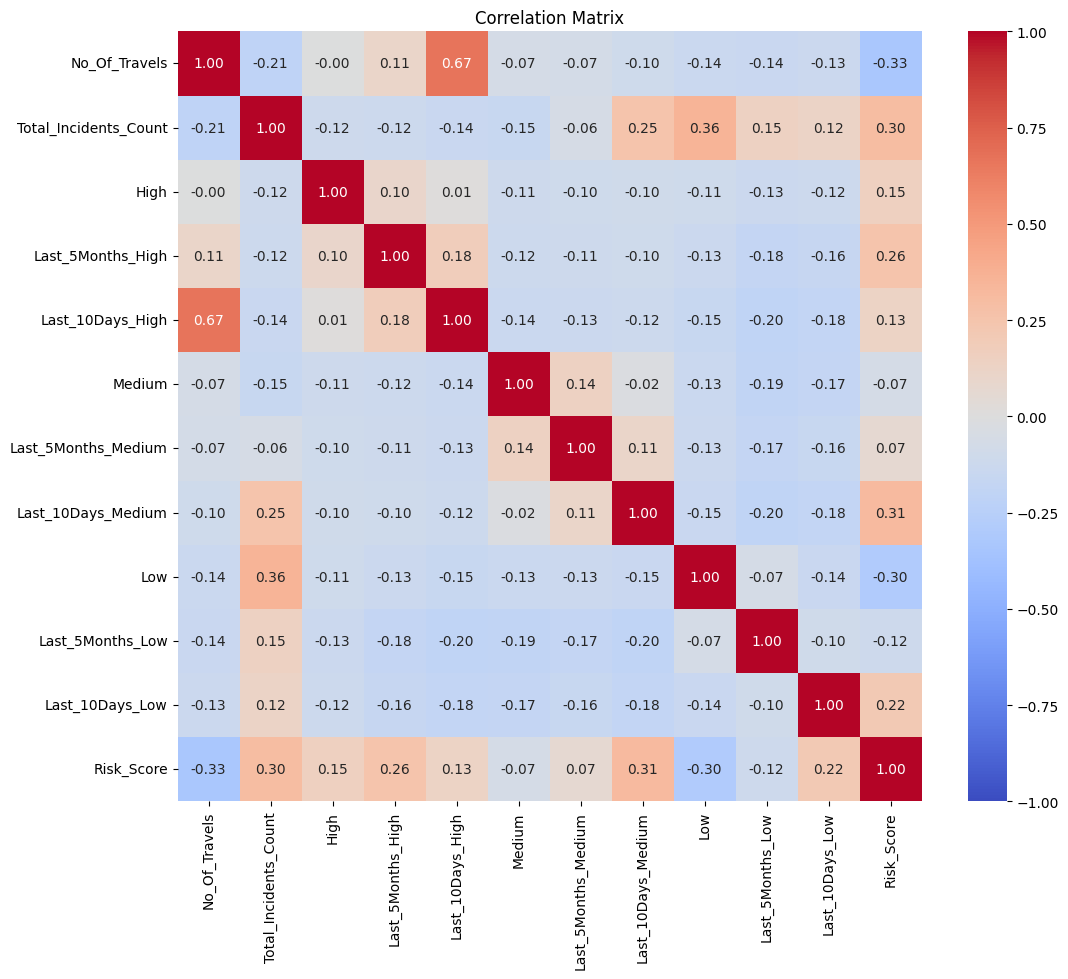

In [24]:
# Compute the correlation matrix
correlation_matrix = new_df_routes[['No_Of_Travels', 'Total_Incidents_Count', 'High', 'Last_5Months_High', 
                         'Last_10Days_High', 'Medium', 'Last_5Months_Medium', 'Last_10Days_Medium',
                         'Low', 'Last_5Months_Low', 'Last_10Days_Low', 'Risk_Score']].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

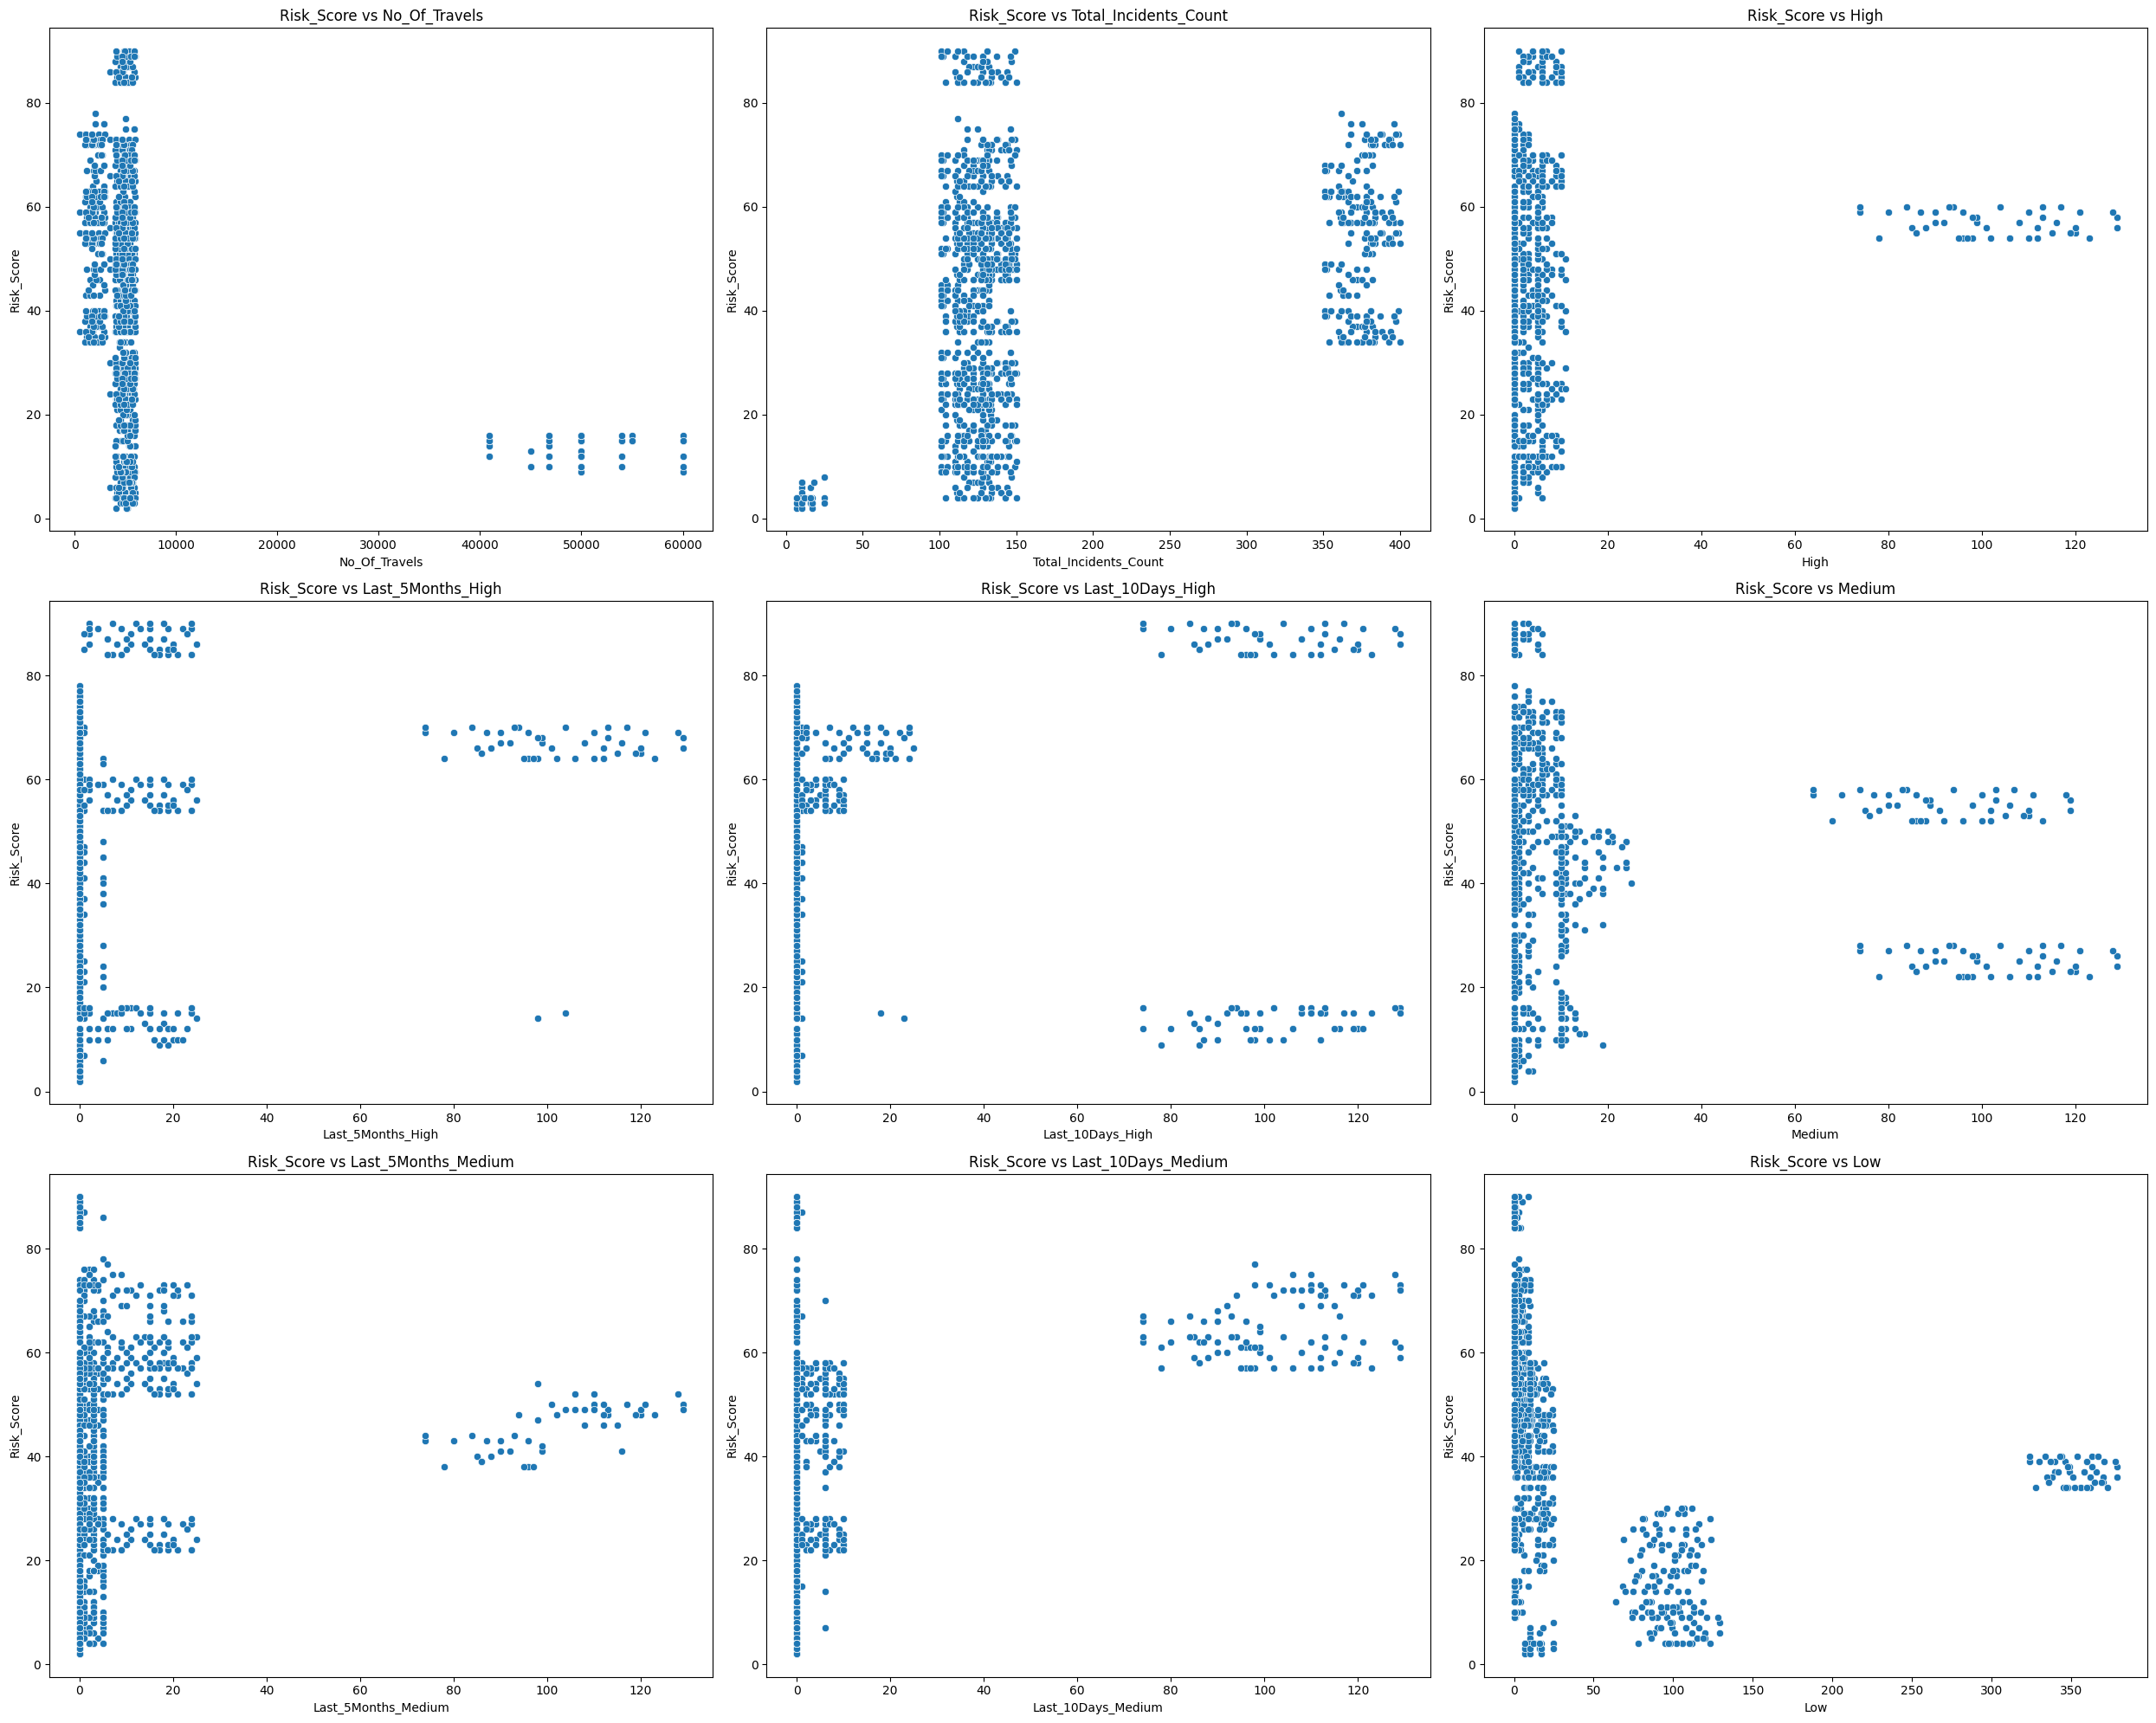

In [25]:
# Create scatter plots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 20))

columns = ['No_Of_Travels', 'Total_Incidents_Count', 'High', 'Last_5Months_High', 
           'Last_10Days_High', 'Medium', 'Last_5Months_Medium', 'Last_10Days_Medium',
           'Low', 'Last_5Months_Low', 'Last_10Days_Low']

for ax, col in zip(axes.flatten(), columns):
    sns.scatterplot(x=new_df_routes[col], y=new_df_routes['Risk_Score'], ax=ax)
    ax.set_title(f'Risk_Score vs {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Risk_Score')

plt.tight_layout()
plt.show()

### Split data into features and target variable

In [26]:

X = new_df_routes.drop(columns=['Risk_Score'])
y = new_df_routes['Risk_Score']

### Split data into training and testing sets

In [27]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Create and train the model

In [28]:

model = LinearRegression()
model.fit(X_train, y_train)



LinearRegression()

#### Make predictions

In [29]:

y_pred = model.predict(X_test)



#### Evaluate the model


In [30]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 80.41010184723969


#### Display the first few predictions


In [31]:
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions_df.head())

      Actual  Predicted
423       57  49.512255
548       54  48.060287
731       69  59.351903
588       70  65.102061
1052       3   9.206980


In [32]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)



#### Evaluating models


In [33]:
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f'Random Forest Mean Squared Error: {rf_mse}')


Random Forest Mean Squared Error: 10.771910483870968


Feature Importances:
No_Of_Travels: 0.1809
Total_Incidents_Count: 0.1183
High: 0.0281
Last_5Months_High: 0.0167
Last_10Days_High: 0.1633
Medium: 0.0512
Last_5Months_Medium: 0.0056
Last_10Days_Medium: 0.0489
Low: 0.3072
Last_5Months_Low: 0.0599
Last_10Days_Low: 0.0197


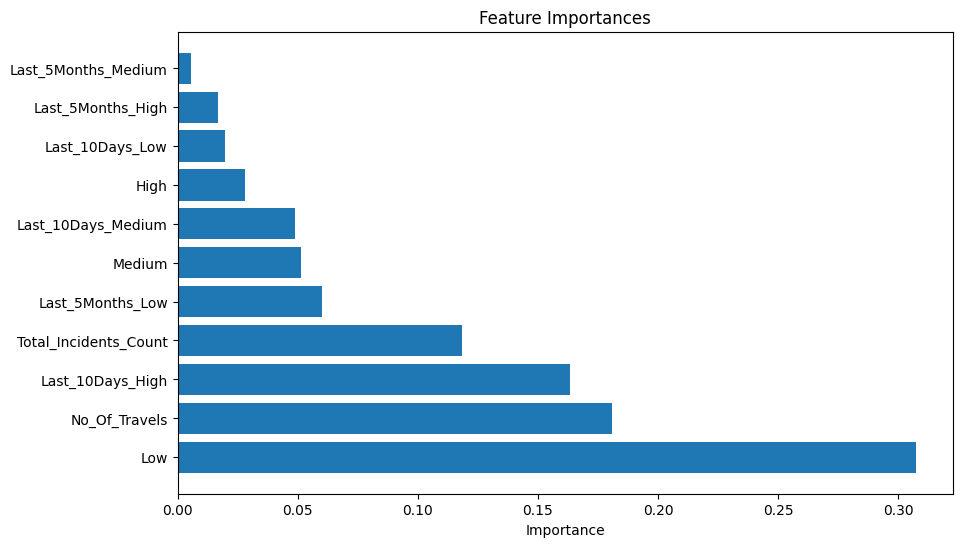

In [34]:
# Get feature importances
importances = rf_model.feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance:.4f}")

# Optional: Visualize feature importances
import matplotlib.pyplot as plt
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

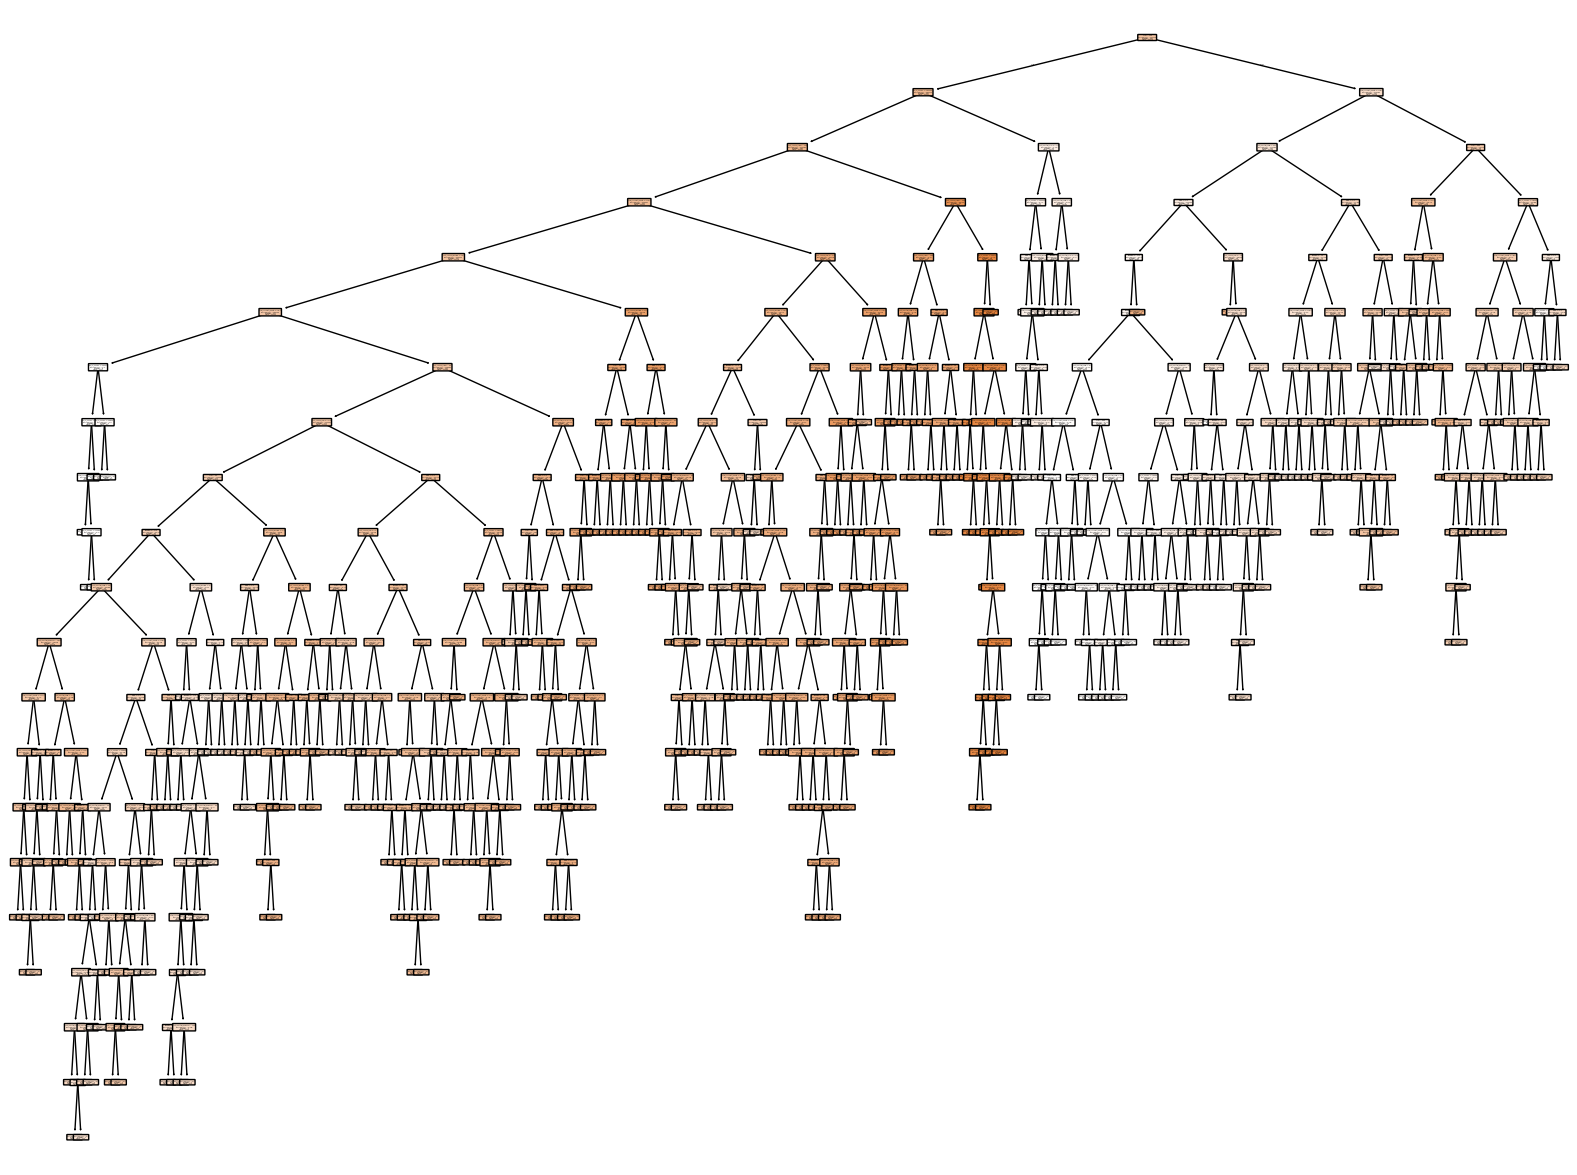

In [35]:
plt.figure(figsize=(20, 15))  # Adjust size as needed
plot_tree(rf_model.estimators_[0], feature_names=X_train.columns, filled=True, rounded=True)
plt.show()



#### Display the first few predictions


In [36]:
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': rf_predictions})
print(predictions_df.head(50))

      Actual  Predicted
423       57     56.890
548       54     52.820
731       69     71.895
588       70     72.175
1052       3      3.145
616       27     27.850
991       89     86.265
993       90     87.075
1072       2      3.685
923       66     64.695
1049      16     14.555
581       70     73.295
634       24     24.780
158       20     28.075
365       50     48.090
448       57     56.335
333       47     46.800
495       34     35.935
912       68     64.940
893       60     56.230
56        17     17.020
70        14     15.900
485       34     36.890
388       47     49.080
528       53     53.075
987       90     87.240
837       63     59.440
371       51     48.560
1030      10     13.870
760       52     56.185
656       40     46.110
679       48     48.930
51        18     15.845
277       46     37.565
174       28     28.805
617       28     31.475
761       57     54.120
86        19     16.980
309       39     45.225
1077       3      2.835
389       53    

#### Serialize the model to a file


In [37]:
with open('risk_model.pkl', 'wb') as f:
    pickle.dump(model, f)

#### Serialize the model to a file


In [38]:
with open('risk_randomforest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)